Got 711 segments for platform: TOYOTA_ALPHARD_TSS2


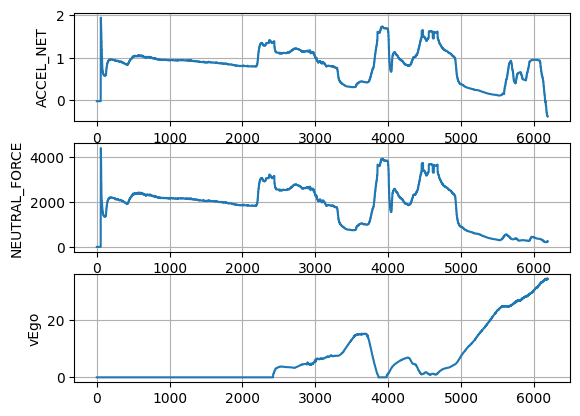

Got 71 segments for platform: TOYOTA_AVALON_TSS2


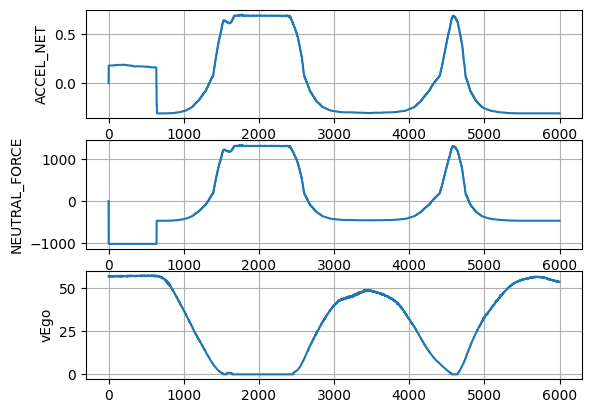

Got 449 segments for platform: TOYOTA_CAMRY


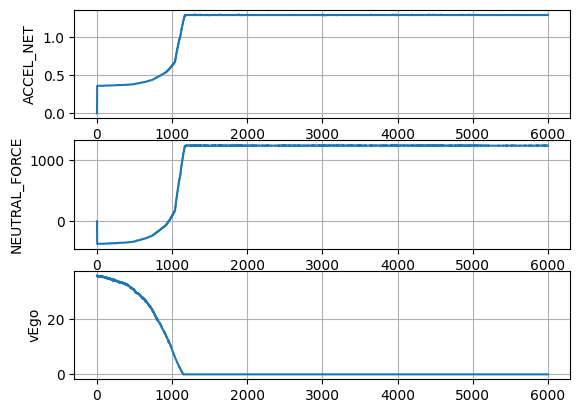

Got 1014 segments for platform: TOYOTA_CAMRY_TSS2


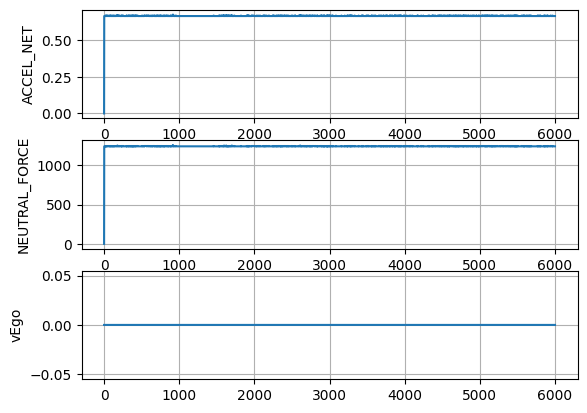

Got 445 segments for platform: TOYOTA_CHR


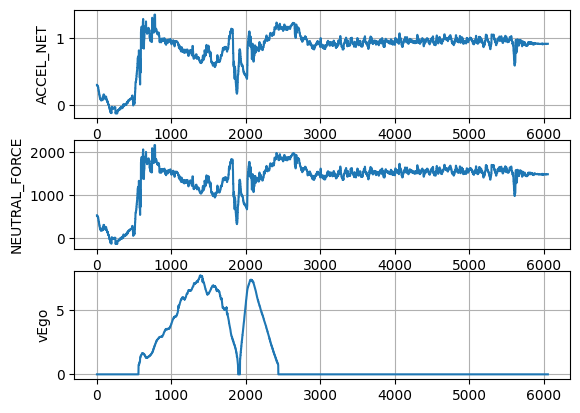

Got 49 segments for platform: TOYOTA_CHR_TSS2


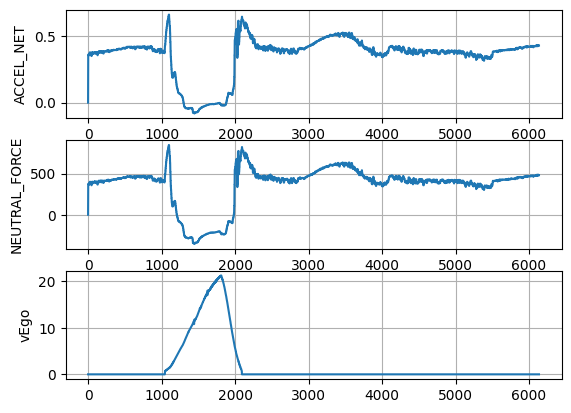

Got 1064 segments for platform: TOYOTA_COROLLA_TSS2


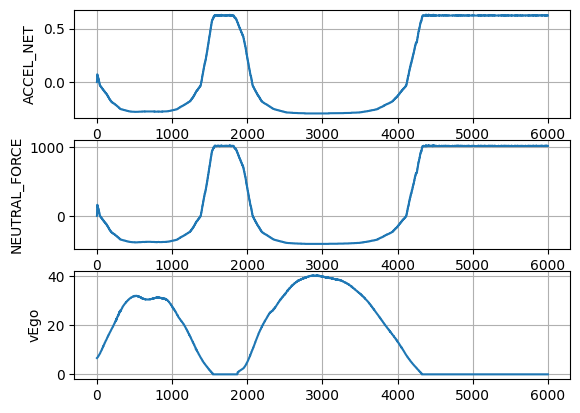

Got 1220 segments for platform: TOYOTA_HIGHLANDER_TSS2


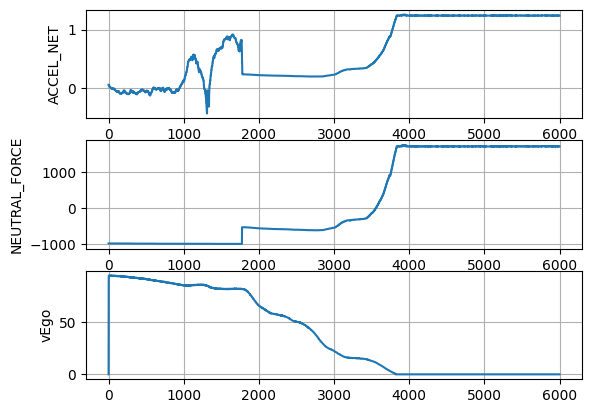

Got 2198 segments for platform: TOYOTA_PRIUS_TSS2


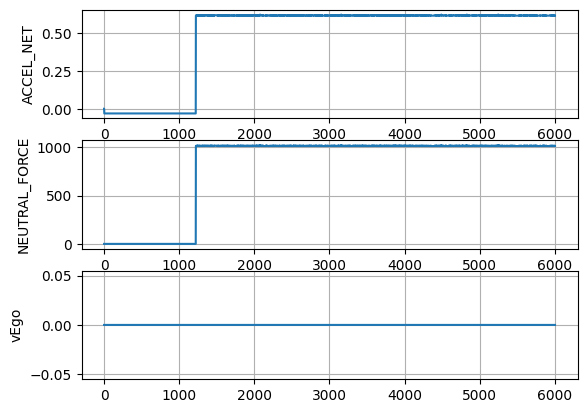

Got 1502 segments for platform: TOYOTA_RAV4_TSS2


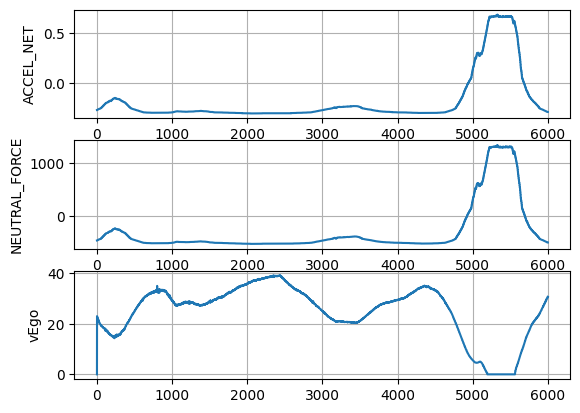

Got 1134 segments for platform: TOYOTA_RAV4_TSS2_2022


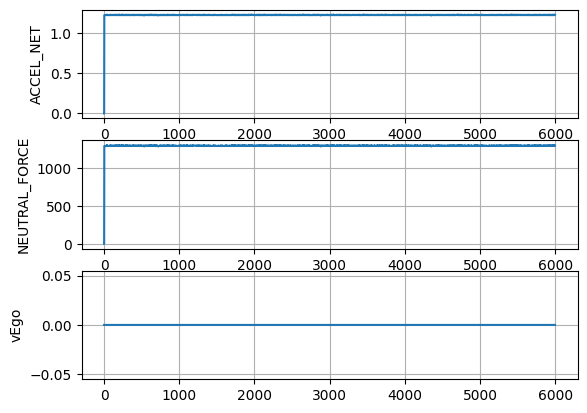

Got 7 segments for platform: TOYOTA_RAV4_TSS2_2023


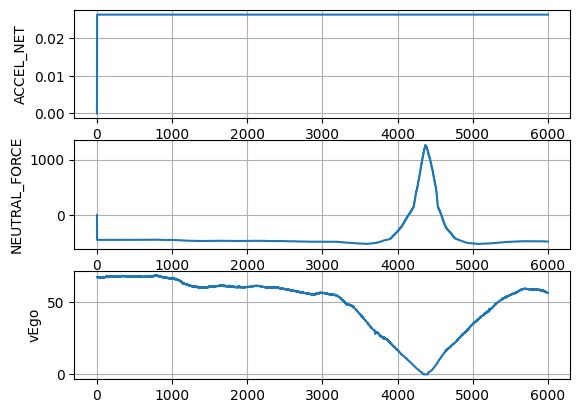

Got 763 segments for platform: TOYOTA_MIRAI


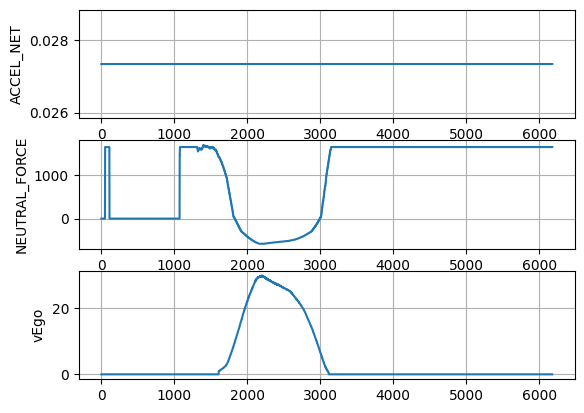

Got 903 segments for platform: LEXUS_ES_TSS2


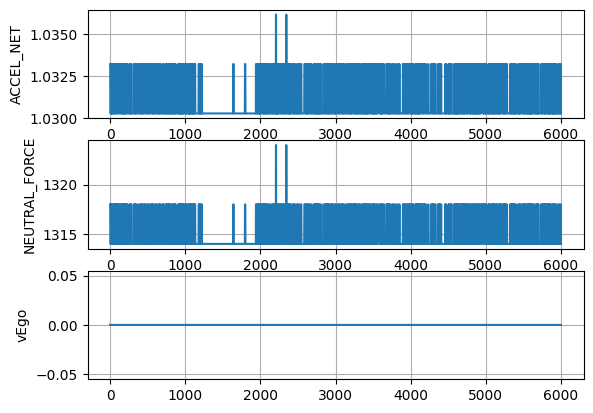

Got 552 segments for platform: LEXUS_IS_TSS2


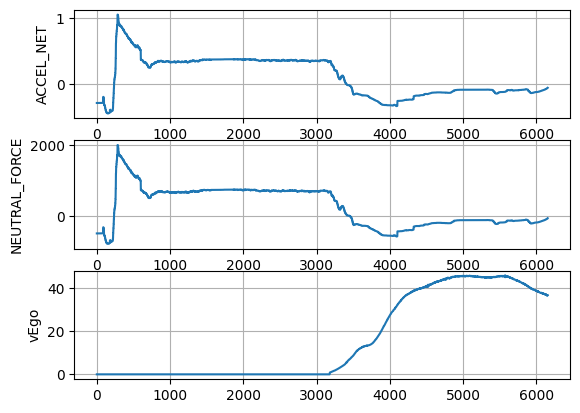

Got 1025 segments for platform: LEXUS_NX_TSS2


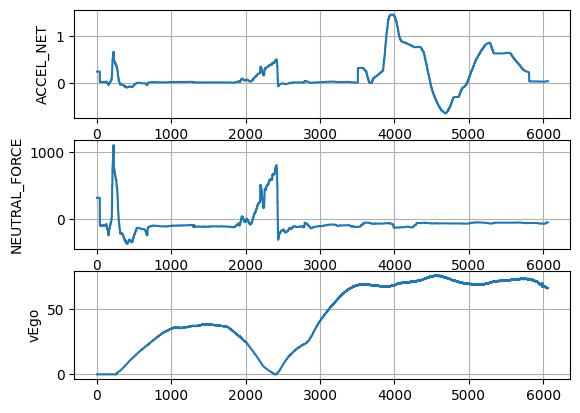

Error: err=KeyError('LEXUS_LC_TSS2'), type(err)=<class 'KeyError'>
Got 1025 segments for platform: LEXUS_LC_TSS2


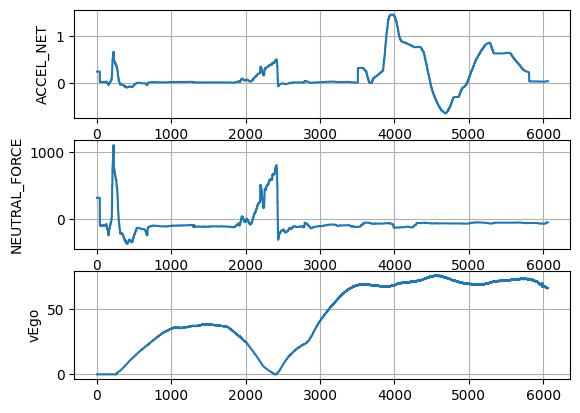

Got 583 segments for platform: LEXUS_RX_TSS2


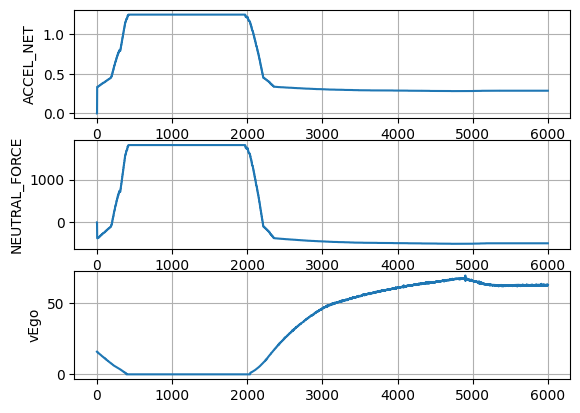

In [4]:
from openpilot.tools.lib.logreader import LogReader
from openpilot.tools.lib.comma_car_segments import get_comma_car_segments_database
from openpilot.selfdrive.car.toyota.values import CAR, NO_DSU_CAR, DBC
from opendbc.can.parser import CANParser
import copy, numpy as np, matplotlib.pyplot as plt

database = get_comma_car_segments_database()

platforms = [c.value for c in CAR]

for platform in platforms:
  if platform in NO_DSU_CAR:
    try:
      all_segments = database[platform]
    except Exception as err:
      print(f"Error: {err=}, {type(err)=}")
    print(f'Got {len(all_segments)} segments for platform: {platform}')

    # try get two examples for each platform
    satisfied = False
    satisfied2 = False

    for segment in all_segments:
      lr = LogReader(segment)
      can_msgs = [msg for msg in lr if msg.which() == "can"]
      messages = [
        ("PCM_CRUISE", 33),
        ("WHEEL_SPEEDS", 80),
      ]
      cp = CANParser(DBC[platform]["pt"], messages, 0)
      pcm_cruise_history = []
      wheel_speeds_history = []
      for msg in can_msgs:
        cp.update_strings([msg.as_builder().to_bytes()])
        pcm_cruise_history.append(copy.copy(cp.vl["PCM_CRUISE"]))
        wheel_speeds_history.append(copy.copy(cp.vl["WHEEL_SPEEDS"]))

      history_acc_net = [msg["ACCEL_NET"] for msg in pcm_cruise_history]
      history_neutral_force_ = [msg["NEUTRAL_FORCE"] for msg in pcm_cruise_history]
      history_wheel_speed = [msg["WHEEL_SPEED_FL"] for msg in wheel_speeds_history]

      for _ in range(len(history_wheel_speed)):
        if _ > 0.25 * len(history_wheel_speed) and history_wheel_speed[_] == 0:
          fig, axs = plt.subplots(3)
          xs = np.arange(0, len(pcm_cruise_history))
          axs[0].plot(xs, history_acc_net)
          axs[0].set_ylabel("ACCEL_NET")
          axs[0].grid(True)
          axs[1].plot(xs, history_neutral_force_)
          axs[1].set_ylabel("NEUTRAL_FORCE")
          axs[1].grid(True)
          axs[2].plot(xs, history_wheel_speed)
          axs[2].set_ylabel("vEgo")
          axs[2].grid(True)
          plt.show()
          if not satisfied:
            satisfied = True
          else:
            satisfied2 = True
          break
      if satisfied and satisfied2:
        satisfied = False
        satisfied2 = False
        break